In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)

In [2]:
# Load in the SST data
ds_train_np = np.load('NOAA_Train_Snapshots.npy')
ds_test_np = np.load('NOAA_Test_Snapshots.npy')
ds_mask = np.load('NOAA_Mask.npy').astype('bool')

In [3]:
# Snapshots numbers
num_train = np.shape(ds_train_np)[0]
num_test = np.shape(ds_test_np)[0]

In [4]:
num_points = np.shape(ds_train_np)[1]*np.shape(ds_train_np)[2]
print('Total number of points in the snapshot:',num_points)

Total number of points in the snapshot: 64800


In [5]:
# Select a random subsample of them
num_sensors = 800
idx = np.arange(num_points,dtype='int')

# Need to remove the masked points
idx = idx[ds_mask.flatten()[:]]
# Shuffle
np.random.shuffle(idx)
idx = idx[:num_sensors]

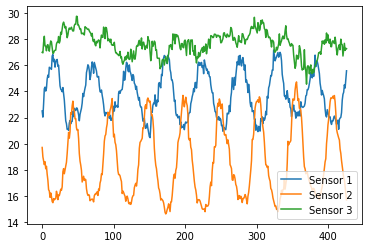

In [6]:
# Lets plot some of the measurements at these locations with time
ds_train_flat = ds_train_np.reshape(np.shape(ds_train_np)[0],np.shape(ds_train_np)[1]*np.shape(ds_train_np)[2])
ds_test_flat = ds_test_np.reshape(np.shape(ds_test_np)[0],np.shape(ds_train_np)[1]*np.shape(ds_train_np)[2])

plt.figure()
plt.plot(ds_train_flat[:,idx[0]],label='Sensor 1')
plt.plot(ds_train_flat[:,idx[1]],label='Sensor 2')
plt.plot(ds_train_flat[:,idx[2]],label='Sensor 3')
plt.legend()
plt.show()

In [7]:
# Load in the latitude and longitude information for sensors alone
lat_grid = np.load('Lat_grid.npy').flatten()
lon_grid = np.load('Lon_grid.npy').flatten()

lon_lon, lat_lat = np.meshgrid(lon_grid,lat_grid)

sensor_lats = lat_lat.flatten()[idx[:]]
sensor_lons = lon_lon.flatten()[idx[:]]

In [9]:
# Find Euclidean distance from neighbors
lon_lat_coods = np.concatenate((sensor_lons.reshape(-1,1),sensor_lats.reshape(-1,1)),axis=-1)
dist_mat = np.zeros(shape=(num_sensors,num_sensors),dtype='double')

for i in range(num_sensors):
    for j in range(num_sensors):
        dist_mat[i,j] = np.sqrt((lon_lat_coods[i,0]-lon_lat_coods[j,0])**2 + (lon_lat_coods[i,1]-lon_lat_coods[j,1])**2)

In [10]:
# Build adjacency matrix for the given sensors based on nearest neighbor interpolation
print('The mean distance is:',np.mean(dist_mat))
print('The standard deviation of the distance is:',np.std(dist_mat))

# Connection threshold
thresh = np.mean(dist_mat) - np.std(dist_mat)
adj_mat = np.copy(dist_mat)

adj_mat[adj_mat>thresh] = 0
adj_mat[adj_mat>0] = 1
np.fill_diagonal(adj_mat,val=1)

The mean distance is: 136.61896816056264
The standard deviation of the distance is: 74.7480380887564


In [11]:
from scipy import sparse
adj_mat = adj_mat.astype('int')
A = np.zeros(shape=(num_train,num_sensors,num_sensors))
A[:,:,:] = adj_mat[None,:,:]

In [12]:
# Now stack features at each node - these features will be the past 4 weeks of weekly means and the lat lon
num_features = 8 # weeks of history
X = np.zeros(shape=(1,num_sensors,num_features),dtype='double')
Y = np.zeros(shape=(1,num_sensors,num_features),dtype='double')

start_id = 0
end_id = start_id + num_features
while end_id != num_train-num_features:
    X_temp = np.expand_dims(np.transpose(ds_train_flat[start_id:end_id,idx[:]]),axis=0)
    X = np.concatenate((X,X_temp),axis=0)
    
    Y_temp = np.expand_dims(np.transpose(ds_train_flat[start_id+num_features:end_id+num_features,idx[:]]),axis=0)
    Y = np.concatenate((Y,Y_temp),axis=0)
    
    start_id+=1
    end_id+=1

X = X[1:]
Y = Y[1:]

# Lets also shuffle
shuffle_idx = np.arange(X.shape[0])
np.random.shuffle(shuffle_idx)
X = X[shuffle_idx]
Y = Y[shuffle_idx]

# Get rid of superfluous A data
A = A[:X.shape[0]]

print('Final shape of training data inputs:',X.shape)
print('Final shape of training data outputs:',Y.shape)
print('Final shape of adjacency matrices:',A.shape)

Final shape of training data inputs: (411, 800, 8)
Final shape of training data outputs: (411, 800, 8)
Final shape of adjacency matrices: (411, 800, 800)


In [13]:
# Lets scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1,num_sensors*num_features))
X = X.reshape(-1,num_sensors,num_features)
Y = scaler.transform(Y.reshape(-1,num_sensors*num_features))
Y = Y.reshape(-1,num_sensors,num_features)

In [14]:
from spektral.layers import GraphConv
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [15]:
# Parameters
channels = 128           # Number of channels in the first layer
N = X.shape[1]          # Number of nodes in the graph
F = X.shape[2]          # Original size of node features
num_outputs = Y.shape[2]  # Number of outputs
dropout = 0.1           # Dropout rate for the features
l2_reg = 0.0       # L2 regularization rate
learning_rate = 1e-4    # Learning rate
epochs = 2000            # Number of training epochs
es_patience = 100        # Patience for early stopping

# Preprocessing operations to scale by degree of vertex
fltr = GraphConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(N, F,))
fltr_in = Input((N, N,), sparse=False)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_1 = Dropout(dropout)(graph_conv_1)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_1 = Dropout(dropout)(graph_conv_1)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_1 = Dropout(dropout)(graph_conv_1)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_1 = Dropout(dropout)(graph_conv_1)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])


dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_outputs,
                         activation=None,
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 8)]     0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 800, 800)]   0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 800, 128)     1024        dropout[0][0]                    
                                                                 input_2[0][0]                

In [ ]:
model.fit([X, fltr],
          Y,
          epochs=2000,
          batch_size=32,
          shuffle=False,  # Shuffling data means shuffling the whole graph
          callbacks=[
              EarlyStopping(patience=10,  restore_best_weights=True)
          ],
         validation_split=0.1)

Epoch 1/2000
12/12 [==============================] - 7s 613ms/step - loss: 0.9906 - val_loss: 0.8850
Epoch 2/2000
12/12 [==============================] - 8s 686ms/step - loss: 0.9784 - val_loss: 0.8731
Epoch 3/2000
12/12 [==============================] - 7s 612ms/step - loss: 0.9642 - val_loss: 0.8578
Epoch 4/2000
12/12 [==============================] - 7s 581ms/step - loss: 0.9452 - val_loss: 0.8367
Epoch 5/2000
12/12 [==============================] - 7s 590ms/step - loss: 0.9188 - val_loss: 0.8085
Epoch 6/2000
12/12 [==============================] - 7s 578ms/step - loss: 0.8835 - val_loss: 0.7736
Epoch 7/2000
12/12 [==============================] - 7s 583ms/step - loss: 0.8400 - val_loss: 0.7347
Epoch 8/2000
12/12 [==============================] - 7s 582ms/step - loss: 0.7914 - val_loss: 0.6944
Epoch 9/2000
12/12 [==============================] - 7s 574ms/step - loss: 0.7421 - val_loss: 0.6540
Epoch 10/2000
12/12 [==============================] - 7s 574ms/step - loss: 0.697

12/12 [==============================] - 7s 568ms/step - loss: 0.5884 - val_loss: 0.5394
Epoch 81/2000
12/12 [==============================] - 7s 551ms/step - loss: 0.5879 - val_loss: 0.5392
Epoch 82/2000
12/12 [==============================] - 7s 575ms/step - loss: 0.5885 - val_loss: 0.5390
Epoch 83/2000
12/12 [==============================] - 7s 578ms/step - loss: 0.5871 - val_loss: 0.5384
Epoch 84/2000
12/12 [==============================] - 7s 589ms/step - loss: 0.5871 - val_loss: 0.5382
Epoch 85/2000
12/12 [==============================] - 7s 591ms/step - loss: 0.5867 - val_loss: 0.5382
Epoch 86/2000
12/12 [==============================] - 7s 589ms/step - loss: 0.5868 - val_loss: 0.5378
Epoch 87/2000
12/12 [==============================] - 7s 571ms/step - loss: 0.5871 - val_loss: 0.5376
Epoch 88/2000
12/12 [==============================] - 7s 553ms/step - loss: 0.5854 - val_loss: 0.5372
Epoch 89/2000
12/12 [==============================] - 7s 551ms/step - loss: 0.5854 - v

12/12 [==============================] - 6s 506ms/step - loss: 0.5666 - val_loss: 0.5239
Epoch 160/2000
12/12 [==============================] - 6s 504ms/step - loss: 0.5675 - val_loss: 0.5240
Epoch 161/2000
12/12 [==============================] - 6s 502ms/step - loss: 0.5670 - val_loss: 0.5247
Epoch 162/2000
12/12 [==============================] - 6s 502ms/step - loss: 0.5663 - val_loss: 0.5235
Epoch 163/2000
12/12 [==============================] - 6s 503ms/step - loss: 0.5657 - val_loss: 0.5237
Epoch 164/2000
12/12 [==============================] - 6s 506ms/step - loss: 0.5647 - val_loss: 0.5230
Epoch 165/2000
12/12 [==============================] - 6s 501ms/step - loss: 0.5650 - val_loss: 0.5233
Epoch 166/2000
12/12 [==============================] - 6s 517ms/step - loss: 0.5653 - val_loss: 0.5227
Epoch 167/2000
12/12 [==============================] - 6s 503ms/step - loss: 0.5654 - val_loss: 0.5228
Epoch 168/2000
12/12 [==============================] - 6s 505ms/step - loss: 0

In [ ]:
# Lets do evaluations on testing - first set up data
X_test = np.zeros(shape=(1,num_sensors,num_features),dtype='double')
Y_test = np.zeros(shape=(1,num_sensors,num_features),dtype='double')

start_id = 0
end_id = start_id + num_features
while end_id < num_test-2*num_features:
    X_temp = np.expand_dims(np.transpose(ds_test_flat[start_id:end_id,idx[:]]),axis=0)    
    X_test = np.concatenate((X_test,X_temp),axis=0)
    
    Y_temp = np.expand_dims(np.transpose(ds_test_flat[start_id+num_features:end_id+num_features,idx[:]]),axis=0)
    Y_test = np.concatenate((Y_test,Y_temp),axis=0)
    
    start_id+=num_features
    end_id+=num_features

X_test = X_test[1:]
Y_test = Y_test[1:]

# Test adjacency matrix
A_test = np.zeros(shape=(num_test,num_sensors,num_sensors))
A_test[:,:,:] = adj_mat[None,:,:]
A_test = A_test[:X_test.shape[0]]

print('Final shape of testing data inputs:',X_test.shape)
print('Final shape of testing data outputs:',Y_test.shape)
print('Final shape of testing adjacency matrix:',A_test.shape)

# Preprocessing operations to scale by degree of vertex
fltr = GraphConv.preprocess(A_test).astype('f4')

In [ ]:
# Reshape
X_test = scaler.transform(X_test.reshape(-1,num_sensors*num_features))
X_test = X_test.reshape(-1,num_sensors,num_features)

Y_test = scaler.transform(Y_test.reshape(-1,num_sensors*num_features))
Y_test = Y_test.reshape(-1,num_sensors,num_features)

In [ ]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([X_test, fltr],
                              Y_test,
                              batch_size=X_test.shape[0])

print(eval_results)

In [ ]:
# Visualize forecasts
Y_pred = model.predict([X_test,fltr])

# Rescale
Y_test = scaler.inverse_transform(Y_test.reshape(-1,num_sensors*num_features))
Y_pred = scaler.inverse_transform(Y_pred.reshape(-1,num_sensors*num_features))

In [ ]:
Y_test = Y_test.reshape(-1,num_sensors,num_features)
Y_pred = Y_pred.reshape(-1,num_sensors,num_features)

# Some reshaping before plotting
Y_test = np.einsum('ijk->jik', Y_test)
Y_pred = np.einsum('ijk->jik', Y_pred)

In [ ]:
Y_test = Y_test.reshape(num_sensors,np.shape(Y_test)[1]*np.shape(Y_test)[2])
Y_pred = Y_pred.reshape(num_sensors,np.shape(Y_pred)[1]*np.shape(Y_pred)[2])

for sensor_loc in range(num_sensors):
    plt.figure()
    plt.plot(Y_test[sensor_loc,:],label='True')
    plt.plot(Y_pred[sensor_loc,:],label='Predicted')
    plt.legend()
    plt.show()